In [37]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot

In [2]:
# Import Dataset
df = pd.read_csv('Clean Tweets.csv')
df.head()

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis
0,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral
1,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt nope thank u countless ori organis fight or...,0.1999,Neutral
2,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",twitter web app,rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral
3,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt roshan pie struggl financi right employ end...,0.0000,Neutral
4,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,babyygirlvenu dm need help bill cash app,0.4019,Neutral


### I see that the first character of every "final source" feature is a space. I'd like to remove that

In [3]:
df['final_sources'] = df.final_sources.str[1:]
df.final_sources[0]

'twitter for iphone'

In [4]:
# Looking for NaN, there appear to be 2 NaN values in text_final because they were all stop-words

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   full_text        2523 non-null   object 
 1   source           2523 non-null   object 
 2   final_sources    2523 non-null   object 
 3   text_final       2521 non-null   object 
 4   Vader Sentiment  2523 non-null   float64
 5   Vader Analysis   2523 non-null   object 
dtypes: float64(1), object(5)
memory usage: 118.4+ KB


In [5]:
df[df.text_final.isna()]

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis
574,My venmo and cashapp are both,"<a href=""http://jillresh.com"" rel=""nofollow"">j...",joey ebooks,NaN,0.0,Neutral
1524,My venmo and cashapp are both,"<a href=""http://jillresh.com"" rel=""nofollow"">j...",joey ebooks,NaN,0.0,Neutral


In [6]:
# filtering the DataFrame to be nonnull values and checking again

df = df[~df.text_final.isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2521 entries, 0 to 2522
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   full_text        2521 non-null   object 
 1   source           2521 non-null   object 
 2   final_sources    2521 non-null   object 
 3   text_final       2521 non-null   object 
 4   Vader Sentiment  2521 non-null   float64
 5   Vader Analysis   2521 non-null   object 
dtypes: float64(1), object(5)
memory usage: 137.9+ KB


In [7]:
# checking to see what the top 3 most frequent tweet sources are:

df.final_sources.value_counts().index[:3]


Index(['twitter for iphone', 'twitter for android', 'twitter web app'], dtype='object')

In [8]:
top_3 = df.final_sources.value_counts().index[:3]

df[df.final_sources.isin(top_3)].final_sources.value_counts()

twitter for iphone     1550
twitter for android     547
twitter web app         344
Name: final_sources, dtype: int64

In [9]:
# creating a new dataframe of just the tweets from the top 3 sources

df_top3 = df[df.final_sources.isin(top_3)]
df_top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2441 entries, 0 to 2522
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   full_text        2441 non-null   object 
 1   source           2441 non-null   object 
 2   final_sources    2441 non-null   object 
 3   text_final       2441 non-null   object 
 4   Vader Sentiment  2441 non-null   float64
 5   Vader Analysis   2441 non-null   object 
dtypes: float64(1), object(5)
memory usage: 133.5+ KB


In [10]:
# creating a category feature identifying the tweet source

sources_map = {
    'twitter for iphone': 0,
    'twitter for android': 1,
    'twitter web app': 2
}
df_top3['labels'] = df_top3.final_sources.map(sources_map)
df_top3['labels'] = df_top3.labels.astype('category')
df_top3.head()

C:\Users\chels\AppData\Local\Temp/ipykernel_15408/3315549810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top3['labels'] = df_top3.final_sources.map(sources_map)
C:\Users\chels\AppData\Local\Temp/ipykernel_15408/3315549810.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top3['labels'] = df_top3.labels.astype('category')


,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis,labels
0,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral,0
1,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt nope thank u countless ori organis fight or...,0.1999,Neutral,0
2,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",twitter web app,rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral,2
3,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt roshan pie struggl financi right employ end...,0.0000,Neutral,0
4,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,babyygirlvenu dm need help bill cash app,0.4019,Neutral,0


In [11]:
df_top3.groupby('labels').count()

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis
labels,,,,,,
0,1550,1550,1550,1550,1550,1550
1,547,547,547,547,547,547
2,344,344,344,344,344,344


In [12]:
# create the corpus for TFIDF

corpus = df_top3['text_final'].values.astype('U')
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)
y = df_top3['labels']

In [13]:
# Split the data into testing & training data sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [14]:
# Looking to make sure they are the same length

X_train.shape

(1952, 3305)

In [15]:
y_train.shape

(1952,)

In [16]:
# fit the training data with a Random Forest Classifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
print("ROC AUC: ", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test,y_pred))

ROC AUC:  0.8720178962058188
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       310
           1       0.61      0.52      0.56       110
           2       0.63      0.32      0.42        69

    accuracy                           0.74       489
   macro avg       0.68      0.58      0.61       489
weighted avg       0.72      0.74      0.72       489

Accuracy: 0.7402862985685071


In [18]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
print("ROC AUC: ", roc_auc_score(y_test, y_prob, multi_class='ovo'))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test,y_pred))

ROC AUC:  0.8508762236672475
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       310
           1       0.61      0.52      0.56       110
           2       0.63      0.32      0.42        69

    accuracy                           0.74       489
   macro avg       0.68      0.58      0.61       489
weighted avg       0.72      0.74      0.72       489

Accuracy: 0.7402862985685071


In [19]:
# this is an article I used to help guide me towards my end-goal

# https://towardsdatascience.com/building-a-user-classifier-using-twitter-data-283dfd0c0e59

### My feedback last week involved addressing how my training data is imbalanced due to ~63% of the instances being in one category. To address this, I would like to try oversampling. For milestone 5 I most definitely would like to collect more data (mine more tweets), but for today I want to focus on oversampling with SMOTE

In [20]:
df_top3.head()

,full_text,source,final_sources,text_final,Vader Sentiment,Vader Analysis,labels
0,@lysisbunny @wheeingloss Dm me if you need hel...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,lysisbunni wheeingloss dm need help bill cash app,0.4019,Neutral,0
1,RT @nope_thank_u: OR countless other Māori org...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt nope thank u countless ori organis fight or...,0.1999,Neutral,0
2,RT @voicesofvv: Driving around to our usual sp...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",twitter web app,rt voicesofvv drive around usual spot weekli d...,0.3612,Neutral,2
3,RT @roshan_pie: I'm struggling financially rig...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,rt roshan pie struggl financi right employ end...,0.0000,Neutral,0
4,@babyygirlvenus Dm me if you need help with bi...,"<a href=""http://twitter.com/download/iphone"" r...",twitter for iphone,babyygirlvenu dm need help bill cash app,0.4019,Neutral,0


In [55]:
X = df_top3['text_final'].values
y = df_top3['labels'].values
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

Class=0, n=1550 (33.333%)
Class=2, n=1550 (33.333%)
Class=1, n=1550 (33.333%)


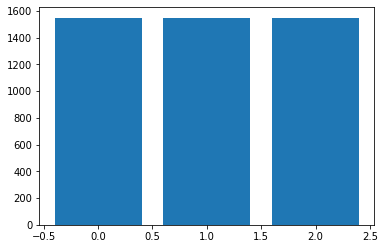

In [56]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [59]:
# Split the data into testing & training data sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [60]:
# Looking to make sure they are the same length

X_train.shape

(3720, 3305)

In [61]:
y_train.shape

(3720,)

In [62]:
# fit the training data with a Random Forest Classifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
print("ROC AUC: ", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test,y_pred))

ROC AUC:  0.9380393687131461
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       310
           1       0.72      0.83      0.77       310
           2       0.84      0.76      0.80       310

    accuracy                           0.80       930
   macro avg       0.80      0.80      0.80       930
weighted avg       0.80      0.80      0.80       930

Accuracy: 0.7956989247311828


### The previous accuracy was 0.74, so this is roughly a 5% improvement in the RandomForestClassifier. I'm hoping that it'll get better as I gather more data (tweets)